## Analysis and Visualization of my Strava Personal Fitness Data from 2018-2021

#### By: Daniel Mayer

### Project Introduction

As an avid endurance athlete, I've been tracking my workouts on fitness app Strava since mid-2018. For this project, I will be practicing data visualization techniques to explore my fitness activity data and highlight key insights. Given the data readily available, this will be a macro-analysis using single aggregated or average values for each activity (i.e. average heart race, average pace). A future in depth micro-analysis could be to upload and analyze the trends within each individual activity.

In addition, I should highlight that the variables that Strava captures are largely numeric, meaning that there will be fewer visualization types that tend to lend themselves to categorical data.

### Research Questions

While I will be wrangling and preparing the full dataset, in this initial analysis I am aiming to answer a few questions about my running (currently the sport I am most dedicated to).

1. Lately I've been experimenting with higher-cadence running to reduce overstriding and injury. I'd like to understand **"How has the change in running cadence impacted my performance?"**


2. Strava provides a data point called "Relative Effort", that seems to give a numerical score for how difficult the workout was. **"What are the key factors that influence relative effort?"**


3. Consistency in mileage is how you improve as a runner, but this has often been a challenge for me given injuries. **"How is my running volume trending over time? When was this the highest?"**


4. The overarching question...I'd like to find a quantitative way to measure **"Am I actually getting fitter over time?"**

#### Import python packages

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import datetime
import regex as re
%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Load in the Strava extract and make a copy using only the fields of interest

I requested a bulk download of all of my data from Strava, which included a .csv file of all of my activities and associated data. In the future, I may look to connect to Strava's API to programmatically download this data and refresh the dataset on a set frequency

In [2]:
df = pd.read_csv('activities.csv')
activities = df.copy()
activities = activities[['Activity ID','Activity Date','Activity Name','Activity Type','Activity Description','Relative Effort',
             'Elapsed Time','Moving Time','Distance.1','Elevation Gain',
             'Average Cadence','Max Heart Rate','Average Heart Rate','Average Watts','Calories','Grade Adjusted Distance',
             'Weather Condition','Weather Temperature','Humidity','Wind Speed']]

activities.rename(columns={'Activity ID':'activity_id','Activity Date':'timestamp','Activity Name':'name','Activity Type':'sport',
                       'Activity Description':'description','Relative Effort':'relative_effort','Elapsed Time':'elapsed_time',
                       'Moving Time':'moving_time','Distance.1':'distance',
                       'Elevation Gain':'elevation_gain','Average Cadence':'cadence','Max Heart Rate':'max_HR',
                       'Average Heart Rate':'avg_HR','Average Watts':'avg_power','Calories':'calories',
                       'Grade Adjusted Distance':'grade_adj_dist','Weather Condition':'weather',
                       'Weather Temperature':'temperature','Humidity':'humidity','Wind Speed':'wind_speed'},inplace=True)

In [3]:
print(activities.shape)
print(activities.dtypes)

(500, 20)
activity_id          int64
timestamp           object
name                object
sport               object
description         object
relative_effort    float64
elapsed_time         int64
moving_time        float64
distance           float64
elevation_gain     float64
cadence            float64
max_HR             float64
avg_HR             float64
avg_power          float64
calories           float64
grade_adj_dist     float64
weather            float64
temperature        float64
humidity           float64
wind_speed         float64
dtype: object


## Data Wrangling

### Data Quality Issues:

General Issues:
- Datatypes for a number of fields are wrong
- Timestamps are incorrect and should be set to Eastern time
- Many numerical values have incorrect minimums of zero, when they should be np.nan
    - Avg_HR of 0 should be converted to NA for Indoor Cycling virtual rides
    - distance of 0
    - max_speed of 0
    - cadence of 0
    - avg_power of 0
- Speed is inaccurate and needs to be recalculated in km/hr
    
Running Specific
- Run Cadence needs to be multiplied by 2 to get steps per minute
- Speed needs to be calculated in km/hr but also pace per km

Swimming Specific
- Calculated field for pace / 100m
- Drop fields like elevation and weather that are irrelevant
- There should be a flag to distinguish between pool and open water swims

### Data Tidiness Issues:
- create a separate dataframe for each sport with associated metrics

#### Start with the issues that need to be fixed for the entire dataset, before moving into sport-specific changes

Fix Datatypes

In [4]:
activities['activity_id'] = activities['activity_id'].astype('object')
activities['timestamp'] = pd.to_datetime(activities['timestamp'])
activities['sport'] = activities['sport'].astype('category')
activities['weather'] = activities['weather'].astype('category')
activities['elapsed_time'] = activities['elapsed_time'].astype('int64')
activities['moving_time'] = activities['moving_time'].astype('int64')

I cannot convert certain fields to int64 given the presence of null values, so as a workaround round them to the nearest whole number

In [5]:
activities['avg_HR'] = activities['avg_HR'].round(decimals=0)
activities['cadence'] = activities['cadence'].round(decimals=0)
activities['avg_power'] = activities['avg_power'].round(decimals=0)
activities['calories'] = activities['calories'].round(decimals=0)

#round distance and elevation to two decimals (that is more than enough accuracy for this investigation)
activities['distance'] = activities['distance'].round(2)
activities['elevation_gain'] = activities['elevation_gain'].round(2)

Use ptyz package to set and convert time zones to Canada/Eastern for all activities

In [6]:
from pytz import timezone

#Set the timezone on all activities to GMT (assumed Strava default)
activities['timestamp'] = activities['timestamp'].dt.tz_localize('GMT')

#Convert the time zone on all activities to Eastern time
activities['timestamp'] = activities['timestamp'].dt.tz_convert('Canada/Eastern')

Some of the activities like indoor rides before I got my sensors have no data on distance, power etc. and are incorrectly listed as 0. Replace 0 with np.nan for these fields to avoid inaccurate patterns in the data.

In [7]:
fields = ['avg_HR','cadence','distance','avg_power']

for field in fields:
    activities[field].replace(0,np.nan,inplace=True)

Calculate speed in km/hr:

In [8]:
activities['speed_kph'] = round((activities['distance'] / activities['moving_time']) * 3.6, 2)

Save clean dataset to csv

In [9]:
activities.to_csv('activities_clean.csv',index=False)

#### Create sport-specific data frames for Running, Cycling, Swimming, and Other to reduce null values and capture sport specific data

This is important to make sure we are comparing apples to apples. You cannot effectively compare speeds of swimming, running, and cycling against one another

In [10]:
running = activities[activities['sport'] == 'Run']
cycling = activities[activities['sport'].isin(['Ride','Virtual Ride'])]
swimming = activities[activities['sport'] == 'Swim']
other = activities[~activities['sport'].isin(['Run','Ride','Virtual Ride','Swim'])]

### Swimming Data

(wrangling for future analyses)

Drop irrelevant columns

In [11]:
swimming = swimming.drop(columns = ['relative_effort','max_HR','avg_HR','avg_power','grade_adj_dist',
                                    'weather','temperature','humidity','wind_speed','elevation_gain'])

Fill in missing distance value

In [12]:
swimming.loc[swimming['distance'].isnull(),'distance'] = 1600

Drop rows with inaccurate distances / speeds due to GPS failure

In [13]:
swimming.drop(index=[352,372,155],inplace=True)

Create calculated field for pace per/100m (this is a classic swimming pace metric)

For the raw dataset, we will keep pace in seconds, but for visualizations we will format the pace into a more understandable format (i.e. 120 seconds --> 2:00/100m)

In [14]:
def format_pace(seconds):
    return re.sub('^0:0','',str(datetime.timedelta(seconds=seconds)))

In [15]:
swimming['pace_100m'] = round((swimming['moving_time'] / (swimming['distance'] / 100)))

### Running Data


Create calculate fields for pace/km (this is a classic running pace metric)

In [16]:
running['pace_km'] = round((running['moving_time'] / (running['distance'] / 1000)))

Double running cadence to get correct steps per minute

In [17]:
running['cadence'] = running['cadence'] * 2

Right now this data is largely numeric variables. To better segment the data and conduct deeper analysis, I will create tiers for Cadence and Relative Effort based on their distributions

In [18]:
#Cadence classes

print(running.describe().cadence) #cadence distribution
bin_edges = [148,160,168,178] #define the bin edges to cut the data into groups
bin_names = ['low','medium','high'] #name each class
running['cadence_class'] = pd.cut(running['cadence'],bin_edges,labels=bin_names) #apply tiering in a new column in df

count    215.000000
mean     163.627907
std        5.687432
min      148.000000
25%      160.000000
50%      162.000000
75%      168.000000
max      178.000000
Name: cadence, dtype: float64


In [19]:
#Relative Effort classes

print(running.describe().relative_effort)
bin_edges = [1,20,50,232]
bin_names = ['low','medium','high']
running['RE_class'] = pd.cut(running['relative_effort'],bin_edges,labels=bin_names)

count    216.000000
mean      29.981481
std       26.736955
min        1.000000
25%       10.750000
50%       24.000000
75%       39.000000
max      232.000000
Name: relative_effort, dtype: float64


## Univariate Exploratory Visualizations

- Overall: explore timestamp (bar chart of activities by year, month, day, hour) and sport (bar chart)
- Running-specific: look at time, distance, pace, HR, cadence, relative effort (histograms/boxplots)

### Number of Activities by Sport

Define a function to add text labels to horizontal bar charts - all credit goes to this StackOverflow post: https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart

In [20]:
def horizontal_bar_labels(ax, spacing=5):

    for rect in ax.patches:
        x_value = rect.get_width()
        y_value = rect.get_y() + rect.get_height() / 2
        space = 5
        ha = 'left'
        label = "{:.0f}".format(x_value)
        
        # Create annotation
        plt.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(space, 0),          # Horizontally shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            va='center',                # Vertically center label
            ha=ha)                      # Horizontally align label differently for
                                        # positive and negative values.

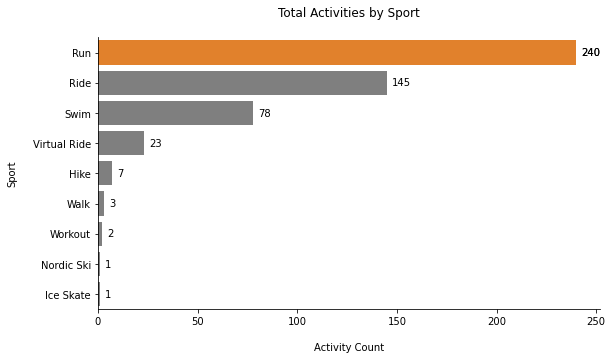

In [21]:
sport_order = activities['sport'].value_counts().index
palette1 = sns.color_palette()[7]
palette2 = sns.color_palette()[1]

fig = plt.figure(figsize=[9,5])
ax = sns.countplot(data = activities, y = 'sport', color=palette1, order=sport_order)
ax = sns.countplot(data = running, y = 'sport', color=palette2, order=sport_order) #highlight running as the top sport
ax.set_xlabel('\nActivity Count')
ax.set_ylabel('Sport\n')
ax.set_title('Total Activities by Sport\n')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
horizontal_bar_labels(ax)
plt.show()

### Time-series exploration: 

Let's breakdown timestamp field to understand some trends in when I exercise.

Define a function to add text labels to bar charts - all credit goes to this StackOverflow post: https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart

In [22]:
def bar_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.0f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

We'll start by looking at total number of activities by sport each year

In [23]:
def plot_activities_year():

    year = activities.groupby(activities["timestamp"].dt.year).timestamp.count()
    run_year = running.groupby(activities["timestamp"].dt.year).timestamp.count()
    bike_year = cycling.groupby(activities["timestamp"].dt.year).timestamp.count()
    swim_year = swimming.groupby(activities["timestamp"].dt.year).timestamp.count()

    xticks = np.arange(2018,2021+1,1)

    ax = sns.lineplot(x=year.index,y=year,color='black',marker='o')
    ax = sns.lineplot(x=run_year.index,y=run_year,color='orange',marker='o')
    ax = sns.lineplot(x=bike_year.index,y=bike_year,color='g',marker='o')
    ax = sns.lineplot(x=swim_year.index,y=swim_year,color='b',marker='o')
    plt.xticks(xticks)
    plt.xlabel('Year')
    plt.ylabel('Activity Count\n')
    plt.title('Activities by Sport by Year\n')
    plt.legend(['All','Running','Cycling','Swimming'],loc="upper left")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()

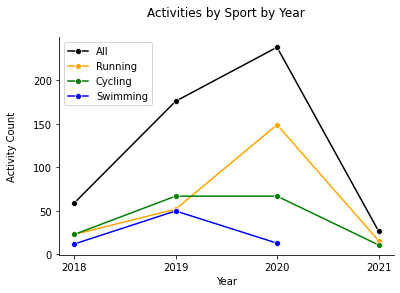

In [24]:
plot_activities_year()

Total runs by year:

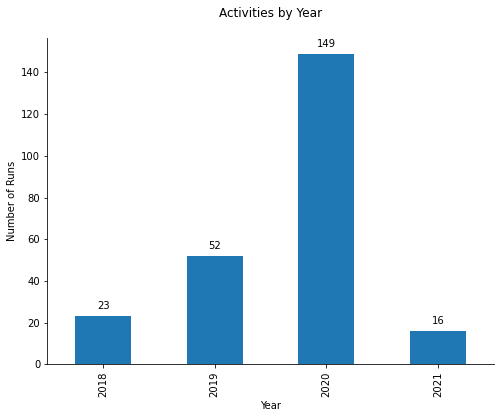

In [25]:
year = running.groupby(activities["timestamp"].dt.year).timestamp.count()
palette = sns.color_palette()[0]

plt.figure(figsize=(8, 6))
ax = year.plot(kind='bar')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Runs')
ax.set_title('Activities by Year\n')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

bar_labels(ax)
plt.show()

Since there's only two FULL years of data (2019 and 2020), we need to segment further in order to gain some meaningful insights

#### Number of Activities by Month

To do this we need to create a combined DataFrame that includes all calendar months in the range, regardless of whether there were activities. October 2018, which had zero activities, needs to appear on the plot.

In [26]:
def activities_by_month(df):

    #step 1: generate a list of all months between the first and last activity
    first = df['timestamp'].dt.strftime("%Y-%m").iloc[0]
    last = df['timestamp'].dt.strftime("%Y-%m").iloc[-1]
    months = pd.date_range(first,last, freq='MS').strftime("%Y-%m").tolist()
    
    #step 2: create two new dataframes and merge them together on month, keeping all calendar months
    calendar_months = pd.DataFrame(months, columns=['calendar_month']) #dataframe with all calendar months
    activity_months = df['timestamp'].groupby(df.timestamp.dt.strftime("%Y-%m")).agg('count') #dataframe with months with activities
    all_months = calendar_months.merge(activity_months, how='left',left_on='calendar_month',right_index=True)
    
    #step 3: prepare new dataframe for plotting
    all_months.replace(np.NaN,0,inplace=True) #replace NaN values with 0 so that months with no activities appear on the plot
    all_months.timestamp = all_months.timestamp.astype(int)
    
    return all_months

Plot for all activities by month

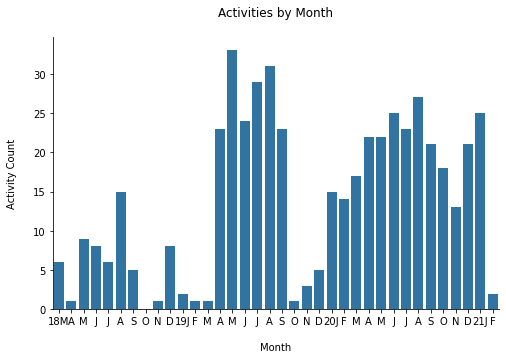

In [27]:
all_months = activities_by_month(activities)
month_labels = ['18M','A','M','J','J','A','S','O','N','D','19J','F','M','A','M','J','J','A','S','O','N','D',
                '20J','F','M','A','M','J','J','A','S','O','N','D','21J','F']
fig = plt.figure(figsize=[8,5])
ax = sns.barplot(x=all_months['calendar_month'],y=all_months['timestamp'],color=palette)
ax.set_xlabel('\nMonth')
ax.set_ylabel('Activity Count\n')
ax.set_title('Activities by Month\n')
ax.set_xticklabels(month_labels)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

Plot all runs by month

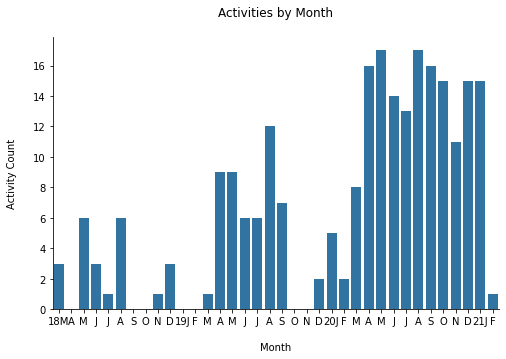

In [28]:
all_months = activities_by_month(running)
month_labels = ['18M','A','M','J','J','A','S','O','N','D','19J','F','M','A','M','J','J','A','S','O','N','D',
                '20J','F','M','A','M','J','J','A','S','O','N','D','21J','F']
fig = plt.figure(figsize=[8,5])
ax = sns.barplot(x=all_months['calendar_month'],y=all_months['timestamp'],color=palette)
ax.set_xlabel('\nMonth')
ax.set_ylabel('Activity Count\n')
ax.set_title('Activities by Month\n')
ax.set_xticklabels(month_labels)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

From the above plots, we can see that while there was a spike in the spring/summer of 2019, 2020 was by far my most consistent year for all activities, but especially running

#### Activity counts by Day of Week

In [29]:
def plot_activities_by_weekday(df):

    weekday = [date.weekday() for date in df['timestamp']]
    days = ["Mon","Tues","Wed","Thurs","Fri","Sat","Sun"]

    fig = plt.figure(figsize=[6,4])
    ax = sns.countplot(weekday,color=palette)
    ax.set_xlabel('\nDay of Week')
    ax.set_ylabel('Activity Count\n')
    ax.set_xticklabels(days)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    bar_labels(ax)
    plt.show()

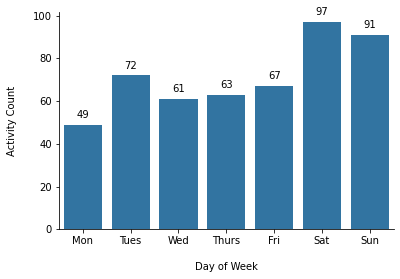

In [30]:
plot_activities_by_weekday(activities)

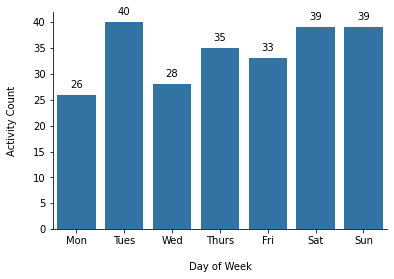

In [31]:
plot_activities_by_weekday(running)

I workout slightly more often on the weekends, which is likely due to the extra free time without work

#### Activity Counts by Time of Day
Note that to save space, hours with zero activities are not shown

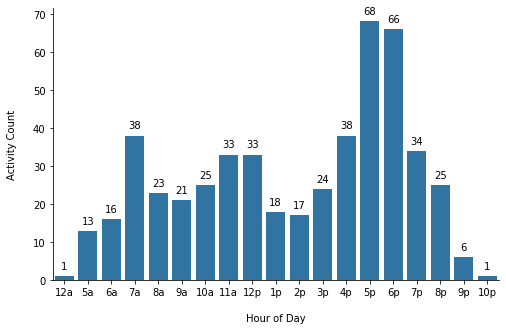

In [32]:
hour = activities.groupby(activities["timestamp"].dt.hour).timestamp.count()
hour_labels = ['12a','5a','6a','7a','8a','9a','10a','11a','12p','1p','2p','3p','4p','5p','6p','7p','8p','9p','10p']

fig = plt.figure(figsize=[8,5])
ax = sns.barplot(x=hour.index,y=hour,color=palette)
ax.set_xlabel('\nHour of Day')
ax.set_ylabel('Activity Count\n')
#plt.xticks(rotation=90)
ax.set_xticklabels(hour_labels)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
bar_labels(ax)
plt.show()

This shows that while I workout across all daylight hours, my most frequent workouts happen in the early evening after work

#### Summary Visualization - Activity Trends Over Time

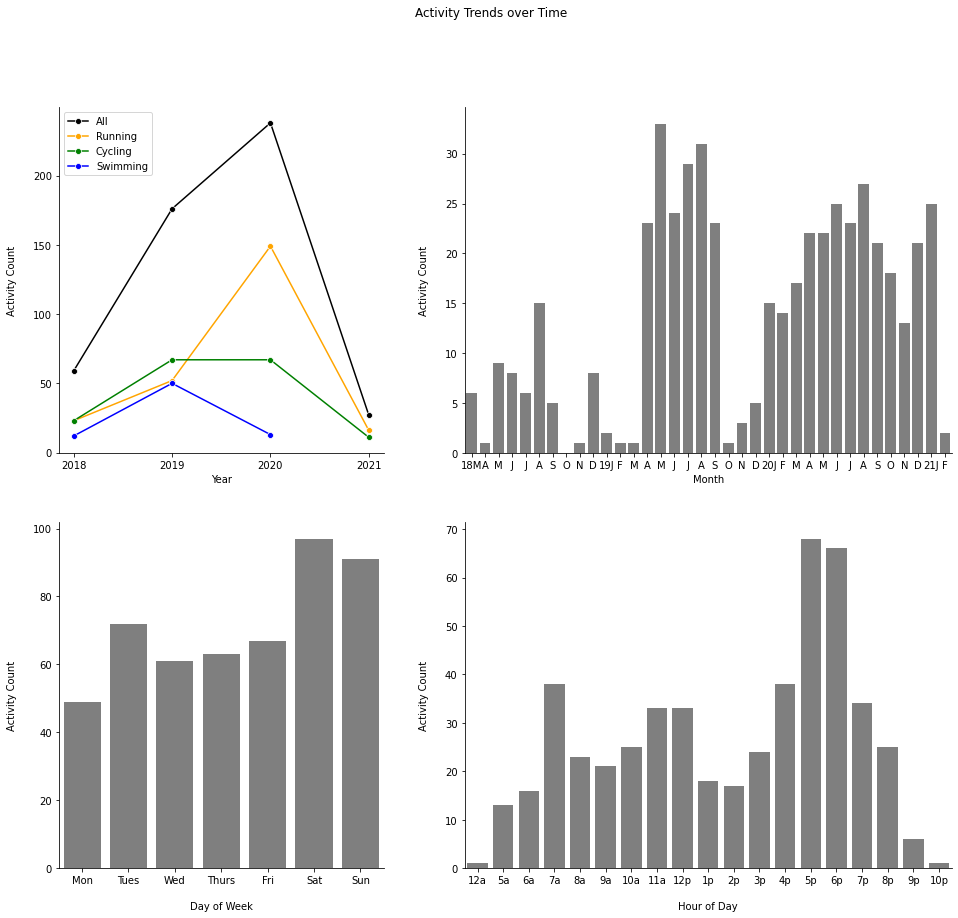

In [33]:
import matplotlib.gridspec as gridspec
palette = sns.color_palette()[7]

fig = plt.figure(figsize=[16,14])
gs = gridspec.GridSpec(2, 2, width_ratios=[1,1.5]) 

fig.suptitle('Activity Trends over Time')

#Activities by Year
year = activities.groupby(activities["timestamp"].dt.year).timestamp.count()
run_year = running.groupby(activities["timestamp"].dt.year).timestamp.count()
bike_year = cycling.groupby(activities["timestamp"].dt.year).timestamp.count()
swim_year = swimming.groupby(activities["timestamp"].dt.year).timestamp.count()
year_xticks = np.arange(2018,2021+1,1)

ax0 = plt.subplot(gs[0])
ax0 = sns.lineplot(x=year.index,y=year,color='black',marker='o')
ax0 = sns.lineplot(x=run_year.index,y=run_year,color='orange',marker='o')
ax0 = sns.lineplot(x=bike_year.index,y=bike_year,color='g',marker='o')
ax0 = sns.lineplot(x=swim_year.index,y=swim_year,color='b',marker='o')
ax0.set_xticks(year_xticks)
ax0.set_xlabel('Year')
ax0.set_ylabel('Activity Count\n')
plt.legend(['All','Running','Cycling','Swimming'],loc="upper left")
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)

#Activities by Month of Year
all_months = activities_by_month(activities)
ax1 = plt.subplot(gs[1])
ax1 = sns.barplot(x=all_months['calendar_month'],y=all_months['timestamp'],color=palette)
ax1.set_xlabel('Month')
ax1.set_ylabel('Activity Count\n')
ax1.tick_params(axis='x')
ax1.set_xticklabels(month_labels)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

#Activities by Day of Week

weekday = [date.weekday() for date in activities['timestamp']]
days = ["Mon","Tues","Wed","Thurs","Fri","Sat","Sun"]

ax2 = plt.subplot(gs[2])
ax2 = sns.countplot(weekday,color=palette)
ax2.set_xlabel('\nDay of Week')
ax2.set_ylabel('Activity Count\n')
ax2.set_xticklabels(days)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

#Activities by Hour

hour = activities.groupby(activities["timestamp"].dt.hour).timestamp.count()
hour_labels = ['12a','5a','6a','7a','8a','9a','10a','11a','12p','1p','2p','3p','4p','5p','6p','7p','8p','9p','10p']

ax3 = plt.subplot(gs[3])
ax3 = sns.barplot(x=hour.index,y=hour,color=palette)
ax3.set_xlabel('\nHour of Day')
ax3.set_ylabel('Activity Count\n')
ax3.set_xticklabels(hour_labels)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

plt.show()

### Exploring Numeric Variable Distributions

#### Histogram of Running Distances

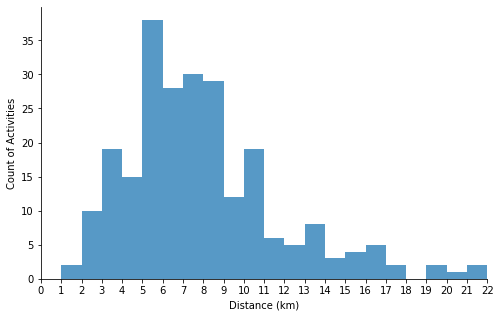

In [34]:
binsize = 1
running['distance_km'] = running['distance'] / 1000
bins = np.arange(0, running['distance_km'].max()+binsize, binsize)

fig = plt.figure(figsize=[8, 5])
ax = sns.histplot(data = running, x = 'distance_km', bins = bins, linewidth=0)
plt.xlim(bins[0], bins[-1])
plt.xlabel('Distance (km)')
plt.xticks(bins)
plt.ylabel('Count of Activities')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

Looks like 5-9 km runs (especially 5km) are my most common

#### Histogram of Running Average Heart Rate

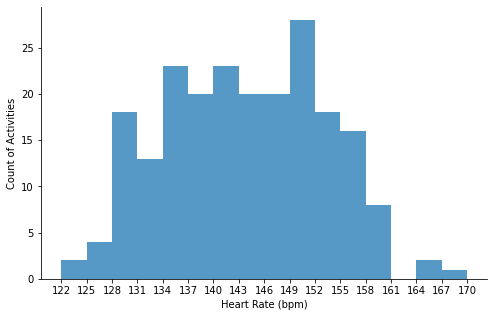

In [35]:
binsize = 3
bins = np.arange(running['avg_HR'].min(), running['avg_HR'].max()+binsize, binsize)

fig = plt.figure(figsize=[8, 5])
ax = sns.histplot(x = running['avg_HR'], bins=bins, linewidth=0)
#plt.xlim(bins[0], bins[-1])
plt.xlabel('Heart Rate (bpm)')
plt.ylabel('Count of Activities')
plt.xticks(bins)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

#### Average Heart Rate Frequency by Percentage

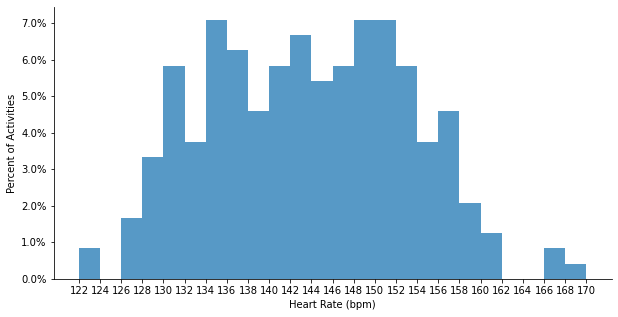

In [36]:
binsize = 2
bins = np.arange(running['avg_HR'].min(), running['avg_HR'].max()+binsize, binsize)
weights = np.ones(len(running['avg_HR'])) / len(running['avg_HR'])

fig = plt.figure(figsize=[10, 5])
ax = sns.histplot(x = running['avg_HR'], bins=bins, linewidth=0, weights=weights)
#plt.xlim(bins[0], bins[-1])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Heart Rate (bpm)')
plt.ylabel('Percent of Activities')
plt.xticks(bins)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

#### Running Pace per km

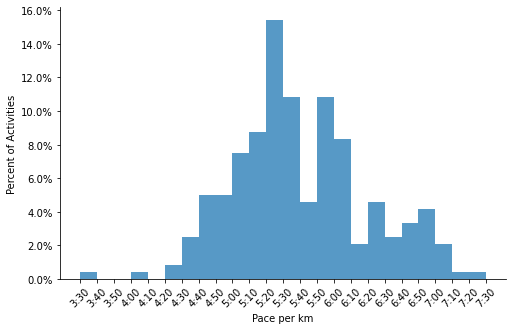

In [37]:
binsize=10
bins = np.arange(running['pace_km'].min()-7, running['pace_km'].max()+binsize, binsize)
weights = np.ones(len(running['pace_km'])) / len(running['pace_km'])

labels = [format_pace(v) for v in bins]

fig = plt.figure(figsize=[8, 5])
ax = sns.histplot(data = running, x='pace_km',bins=bins,linewidth=0,weights=weights)
#plt.xlim(bins[0], bins[-1])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Pace per km')
plt.ylabel('Percent of Activities')
plt.xticks(bins,labels,rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

#### Running Cadence

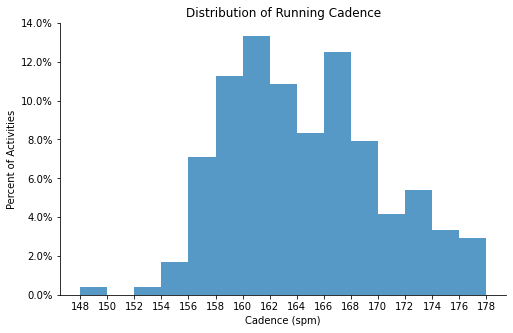

In [74]:
binsize = 2
bins = np.arange(running['cadence'].min(), running['cadence'].max()+binsize, binsize)
weights = np.ones(len(running['cadence'])) / len(running['cadence'])

fig = plt.figure(figsize=[8, 5])
ax = sns.histplot(x = running['cadence'], bins=bins, linewidth=0, weights=weights)
#plt.xlim(bins[0], bins[-1])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Cadence (spm)')
plt.ylabel('Percent of Activities')
plt.title('Distribution of Running Cadence')
plt.xticks(bins)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

#### Running Relative Effort

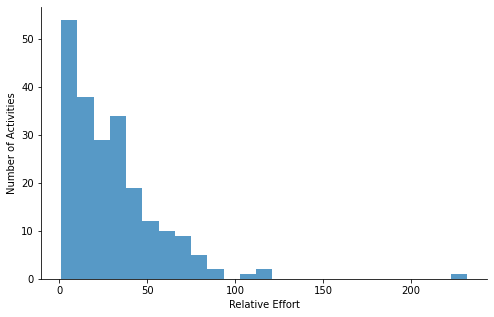

In [39]:
fig = plt.figure(figsize=[8, 5])
ax = sns.histplot(x = running['relative_effort'], linewidth=0)
plt.xlabel('Relative Effort')
plt.ylabel('Number of Activities')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

The vast majority of activities have a relative effort below 40, but it's a bit difficult to see given the long tail of the right-skewed distribution.

Let's do a **log transformation** on the x-axis to more clearly see the distribution of relative effort. We'll also use percentages rather than counts on the y-axis

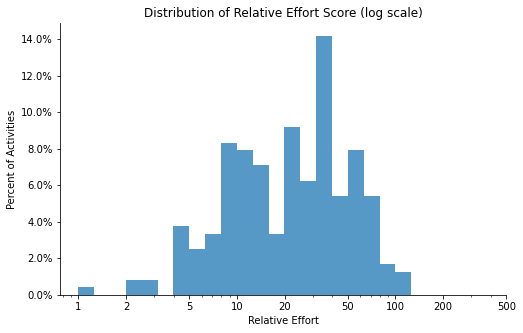

In [75]:
np.log10(running['relative_effort'].describe()) #determine the min and max values on a log scale
bins = 10 ** np.arange(0,2.4,0.1) #set the bins using the min and max log values and arbitrary step size
ticks = [1,2,5,10,20,50,100,200,500]
labels = ['{}'.format(v) for v in ticks]
weights = np.ones(len(running['cadence'])) / len(running['cadence'])

fig = plt.figure(figsize=[8, 5])
ax = sns.histplot(x = running['relative_effort'], linewidth=0,bins=bins,weights=weights)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Relative Effort')
plt.ylabel('Percent of Activities')
plt.title('Distribution of Relative Effort Score (log scale)')
plt.xscale('log')
plt.xticks(ticks,labels)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

Now we can more clearly see that relative efforts between 30-40 are most frequent (~14%), and that about 40% of runs had a relative effort score of below 20

#### What is the max outlier in relative effort?

In [41]:
running.loc[running['relative_effort'].idxmax()]

activity_id                                               2731952682
timestamp                                  2019-09-22 11:58:47-04:00
name                                            Barrelman 70.3 - Run
sport                                                            Run
description        Total flame out in the heat but really happy w...
relative_effort                                                  232
elapsed_time                                                    7231
moving_time                                                     7147
distance                                                     20616.1
elevation_gain                                                   145
cadence                                                          158
max_HR                                                           172
avg_HR                                                           159
avg_power                                                        NaN
calories                          

Ah yes, it was the half marathon in 30 degree heat at the end of the Barrelman 70.3 Triathlon. Good times!

## Bivariate Exploratory Visualizations

We will start by looking at overarching relationships and correlations between variables, before diving deeper into the highlighted research questions

#### Lists of variables of interest

In [42]:
numeric_vars = ['relative_effort','moving_time','distance','pace_km','elevation_gain','cadence','avg_HR']
categorical_vars = ['cadence_class','RE_class']

#### Let's do a simple correlation heatmap to get numerical values on the relationships between quantitative variables

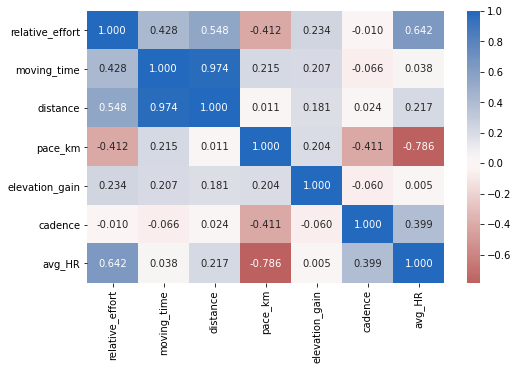

In [43]:
# correlation plot
plt.figure(figsize = [8, 5])
sns.heatmap(running[numeric_vars].corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0)
plt.show()

#### Observations here: 
1. The attributes most highly correlated with Relative Effort are Heart Rate and Distance, though time and pace (faster) also show a moderate correlation.

2. This is fairly intuitive, but an increase in running cadence is associated with an increased average heart rate as well as a faster pace

#### For a little more visual detail on the relationships between numerical variables, we will create a pairplot

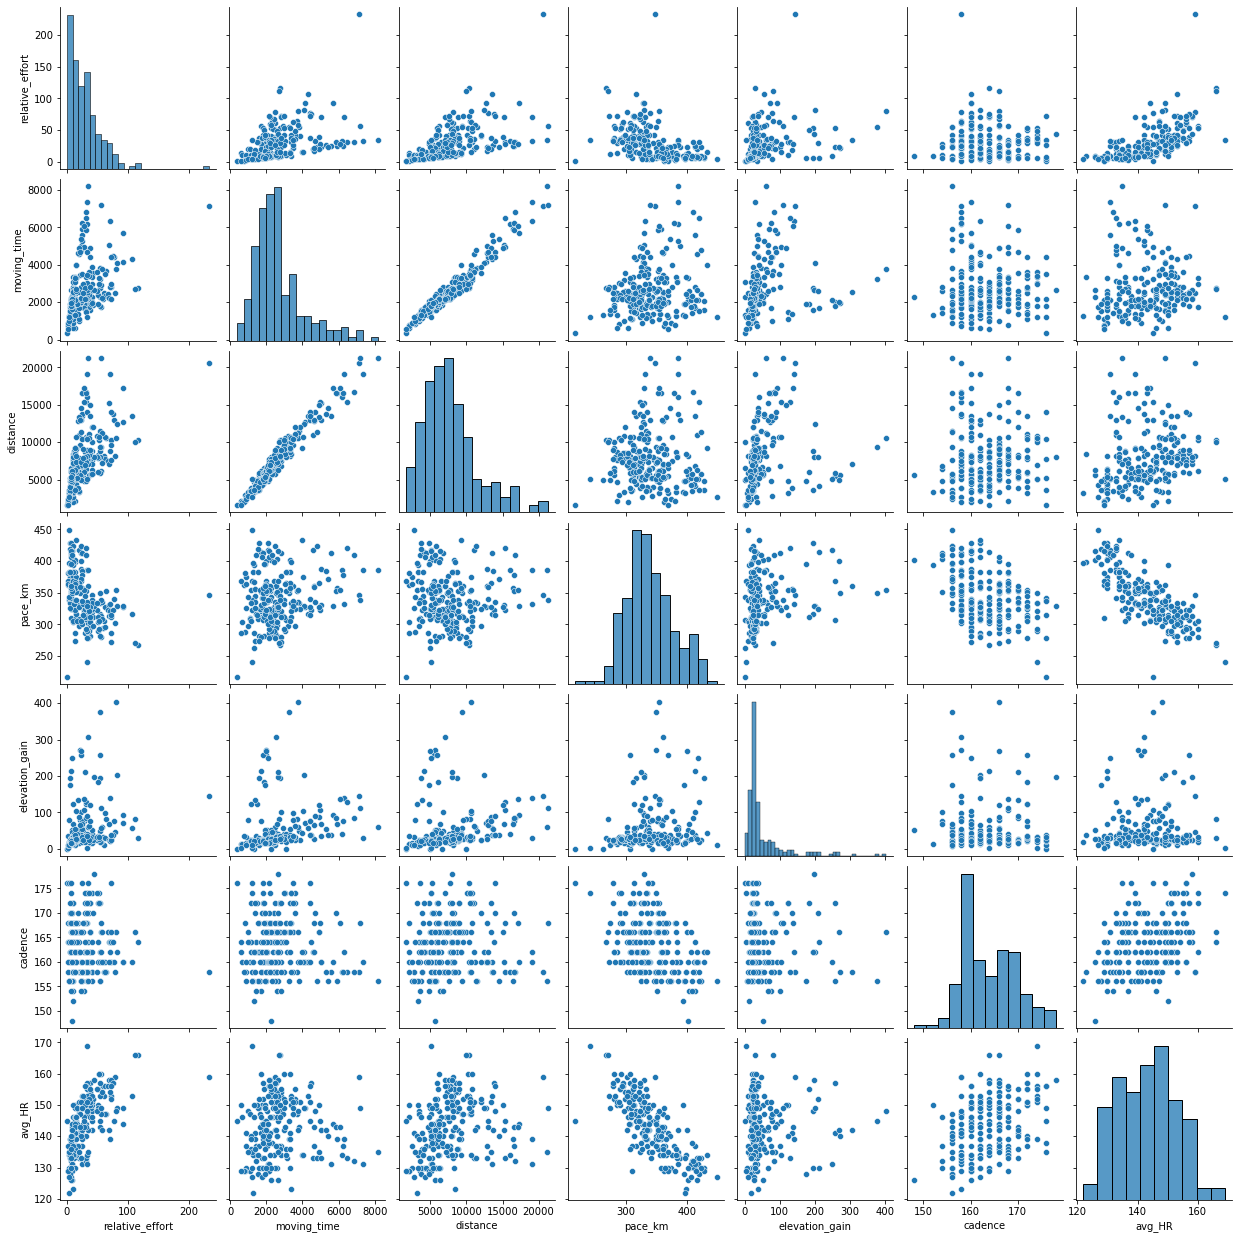

In [44]:
g = sns.pairplot(data= running, vars = numeric_vars)
g = g.map_diag(plt.hist, bins = 20);
g.map_offdiag(plt.scatter)
plt.show()

### Deeper Dives

#### 1. How does running cadence impact my performance?

#### Bivariate Exploration of Cadence

First let's create boxplots to examine how numerical variables are impacted by different cadence levels (low, medium, and high)

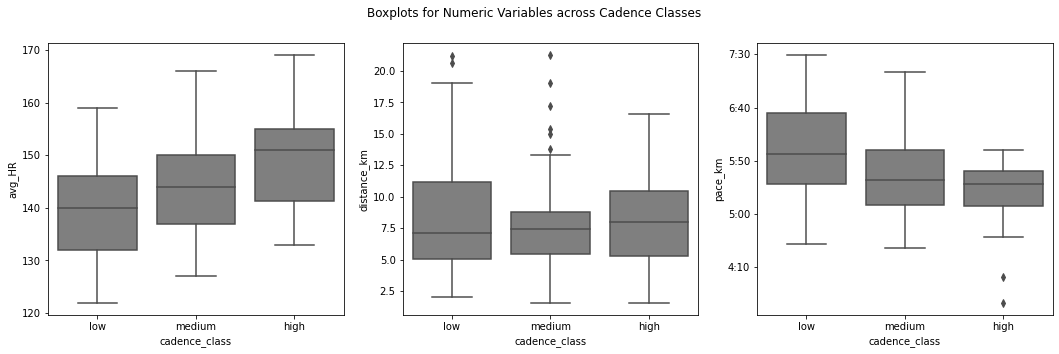

In [45]:
fig, ax = plt.subplots(ncols=3, figsize = [18,5],sharex=True)
plt.suptitle('Boxplots for Numeric Variables across Cadence Classes')

pace_yticks = [250,300,350,400,450]
pace_labels = [format_pace(v) for v in pace_yticks]

palette = sns.color_palette()[7]
sns.boxplot(data= running, x= 'cadence_class', y='avg_HR', color=palette, ax= ax[0])
sns.boxplot(data= running, x= 'cadence_class', y='distance_km', color=palette, ax= ax[1])
sns.boxplot(data= running, x= 'cadence_class', y='pace_km', color=palette, ax= ax[2])
ax[2].set_yticks(pace_yticks)
ax[2].set_yticklabels(pace_labels)

plt.show()

#### Interpretation: 
The box shows the interquartile range, with the horizontal line as the median. The whiskers extend out toward the min/max values, up to 1.5X the interquartile range. Any points beyond that are shown as individual marks - these are outliers in the data

Average HR - A high cadence is associated with a higher median HR, though there is some overlap with medium and low cadences. The spread of the IQR is consistent across cadence classes.

Distance - The spread is much larger with low cadence, as some runs were less than 2.5km while others were over 20km. The median distance is roughly the same for all cadence levels. The longer runs are considered outliers, beyond 1.5X the interquartile range

Pace - The spread of paces is more compact for high cadence runs compared to low or medium cadence. There were hardly any high cadence runs above 6:00/km pace. The outliers are a couple of fast races that are not normal training

Before we move on to multivariate exploration of cadence, let's plot average cadence over time (aggregated to a monthly level)

C:\Users\danie\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1091: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


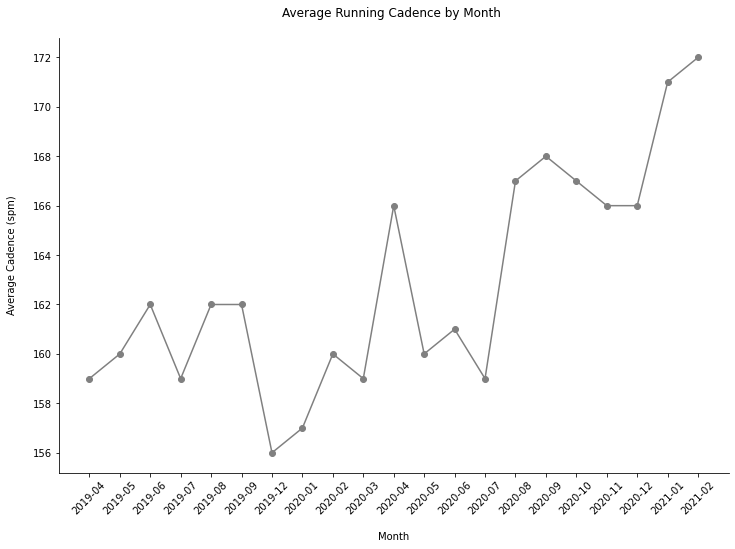

In [46]:
#plot cadence over time
#sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()

cadence_month = running.groupby(activities.timestamp.dt.to_period("M")).cadence.mean().round()
cadence_month = cadence_month.reset_index()
cadence_month = cadence_month[cadence_month['cadence'].notnull()]
cadence_month['timestamp'] = cadence_month['timestamp'].astype(str)

fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.plot(cadence_month['timestamp'],cadence_month['cadence'],c='grey',marker='o')
plt.xticks(rotation=45)
ax.set_xlabel('\nMonth')
ax.set_ylabel('Average Cadence (spm)\n')
ax.set_title('Average Running Cadence by Month \n')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

This line chart illustrates my recent trend of trying to run at a higher cadence in recent months

#### Multivariate Exploration of Cadence

We will create a scatterplot of pace versus heart rate (the two variables most correlated with cadence), and use the numerical cadence as colour to distinguish individual points

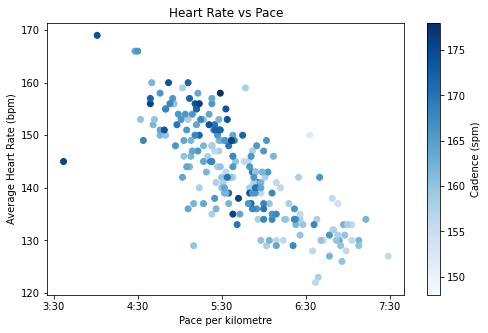

In [47]:
fig = plt.figure(figsize=[8,5])

step_size= 60
pace_xticks = np.arange(running['pace_km'].min()-7, running['pace_km'].max()+step_size, step_size)
pace_labels = [format_pace(v) for v in pace_xticks]

ax = plt.scatter(data=running,x='pace_km',y='avg_HR',c='cadence',cmap='Blues')
cbar = plt.colorbar()
cbar.set_label('Cadence (spm)',labelpad=5)

plt.xticks(pace_xticks,pace_labels)
plt.xlabel('Pace per kilometre')
plt.ylabel('Average Heart Rate (bpm)')
plt.title('Heart Rate vs Pace')
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)

plt.show()

Interpretation: While there are not clear distinctions, we can see that generally the runs with higher average heart rates and faster paces had a higher cadence

What if we try the same plot, but using categorical cadence classes as the third colour variable. Will this uncover any clearer trends?

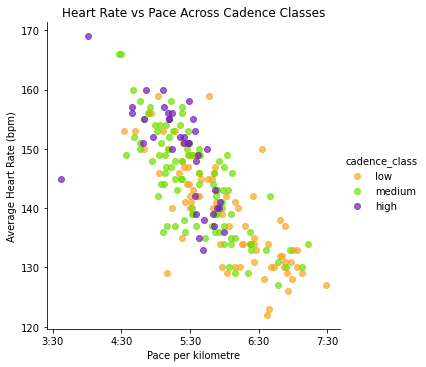

In [48]:
color = {'color': ['#f9a620','#70e000','#721cb8']}

step_size= 60
pace_xticks = np.arange(running['pace_km'].min()-7, running['pace_km'].max()+step_size, step_size)
pace_labels = [format_pace(v) for v in pace_xticks]

g = sns.FacetGrid(data=running, hue='cadence_class', hue_kws=color, height=5)
g.map(plt.scatter,'pace_km','avg_HR',alpha=0.7)
g.add_legend()
g.set(xticks=pace_xticks)
g.set_xticklabels(pace_labels)

plt.xlabel('Pace per kilometre')
plt.ylabel('Average Heart Rate (bpm)')
plt.title('Heart Rate vs Pace Across Cadence Classes')

plt.show()

The high-cadence activities definitely stand out a bit more, and it's interesting to note that there seems to be a pace and heart rate baseline for high cadence activities. There are no purple data points slower than about 6:00/km and with an average heart rate lower than 130. It makes sense, as the body needs to work harder but in turn will go faster if the legs are turning over more quickly. There is also not a lot of different in pace between my medium and high cadence runs. This may change after a few more months of high-cadence training

Now let's split up the data into separate scatterplots for each cadence class, using faceting

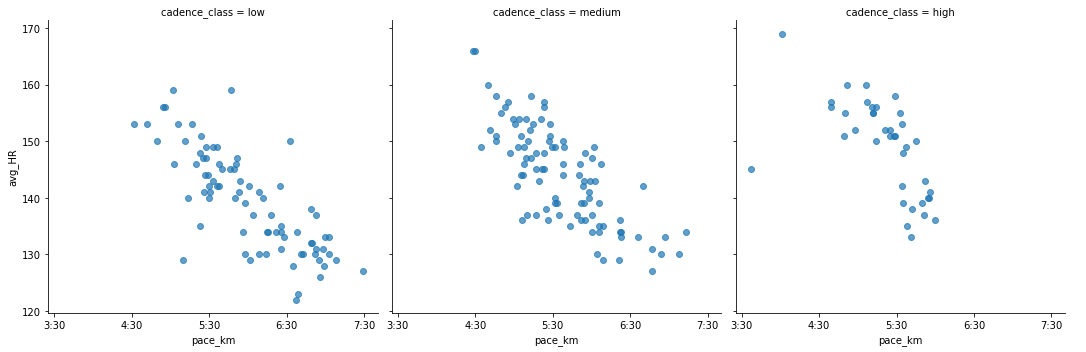

In [49]:
step_size= 60
pace_xticks = np.arange(running['pace_km'].min()-7, running['pace_km'].max()+step_size, step_size)
pace_labels = [format_pace(v) for v in pace_xticks]

g = sns.FacetGrid(data=running, col='cadence_class', height=5)
g.map(plt.scatter,'pace_km','avg_HR',alpha=0.7)
g.add_legend()
g.set(xticks=pace_xticks)
g.set_xticklabels(pace_labels)

plt.show()

From the few data points we have with high cadence, it looks like heart rate is increasingat a faster rate than pace is getting faster. The relationship seems less balanced. However, there is simply not enough data to make that conclusion - more data points from running at higher cadence will be necessary to compare the overall trend and shape of the heart rate vs pace distribution

####  2. What factors impact a high relative effort?

Strava uses a calculated value called Relative Effort to assess each activity. We learned from the correlation heatmap that the attributes most highly correlated with Relative Effort are Heart Rate and Distance, though time and pace (faster) also show a moderate correlation.

#### Bivariate Exploration

Let's start by running some basic bivariate scatterplots using Seaborn's regplot function

Distance vs Relative Effort

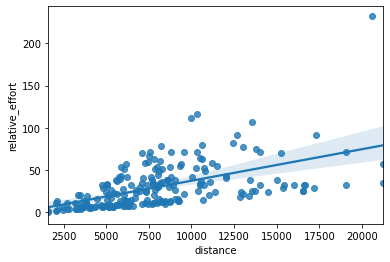

In [50]:
sns.regplot(data = running, x='distance',y='relative_effort')
plt.show()

Heart Rate vs Relative Effort

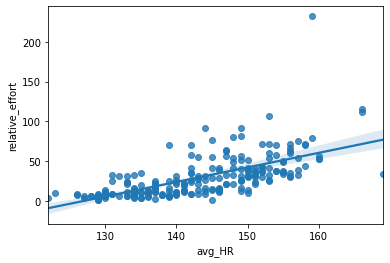

In [51]:
sns.regplot(data = running, x='avg_HR',y='relative_effort')
plt.show()

Pace vs Relative Effort

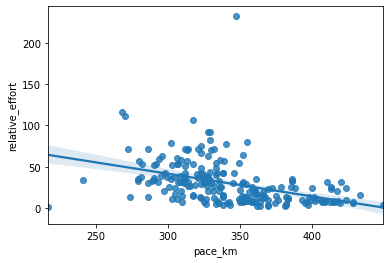

In [52]:
sns.regplot(data = running, x='pace_km',y='relative_effort')
plt.show()

Just like we did with cadence, we will also creat boxplots to compare how numerical variables change within different classes of Relative Effort

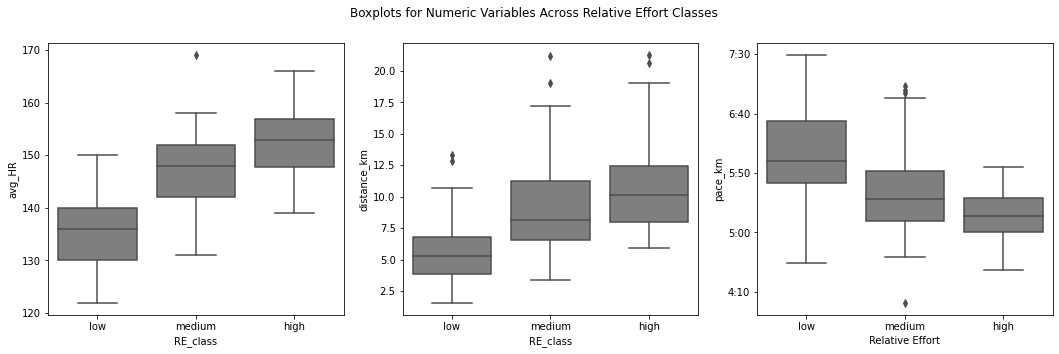

In [53]:
fig, ax = plt.subplots(ncols=3, figsize = [18,5],sharex=True)
plt.suptitle('Boxplots for Numeric Variables Across Relative Effort Classes')

pace_yticks = [250,300,350,400,450]
pace_labels = [format_pace(v) for v in pace_yticks]

palette = sns.color_palette()[7]
sns.boxplot(data= running, x= 'RE_class', y='avg_HR', color=palette, ax= ax[0])
sns.boxplot(data= running, x= 'RE_class', y='distance_km', color=palette, ax= ax[1])
sns.boxplot(data= running, x= 'RE_class', y='pace_km', color=palette, ax= ax[2])
plt.xlabel('Relative Effort')
ax[2].set_yticks(pace_yticks)
ax[2].set_yticklabels(pace_labels)

plt.show()

#### Interpretation: 
The box shows the interquartile range, with the horizontal line as the median. The whiskers extend out toward the min/max values, up to 1.5X the interquartile range. Any points beyond that are shown as individual marks - these are outliers in the data

Average HR - A high Relative Effort is associated with a higher median HR, though there is quite a large overlap in interquartile range between the medium and high classes

Distance - The distribution of distance increases with Relative Effort Class, but not as sharply as with heart rate. Once again, there are a handful of long runs considered outliers.

Pace - The spread of paces is more compact for high Relative Effort runs compared to low or medium RE.. There were hardly any high RE runs above 6:00/km pace. Interesting that the whiskers for the medium Relative Effort box extend for below the high Relative Effort.

#### Multivariate Exploration

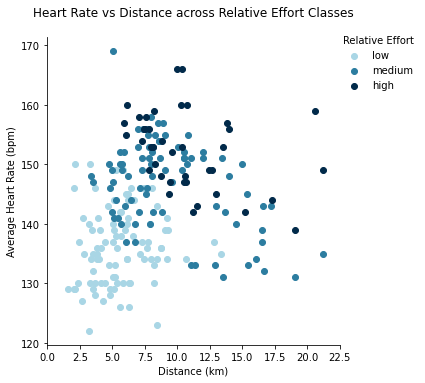

In [73]:
dist_xticks = [0,2500,5000,7500,10000,12500,15000,17500,20000,22500]
dist_labels = [v/1000 for v in dist_xticks]

color = {'color': ['#a9d6e5','#2c7da0','#012a4a']}

g = sns.FacetGrid(data=running, hue='RE_class', hue_kws=color, height=5)
g.map(plt.scatter,'distance','avg_HR')
g.add_legend(title= 'Relative Effort',loc='upper right', bbox_to_anchor=(1, 1))
g.set(xticks=dist_xticks)
g.set_xticklabels(dist_labels)

plt.xlabel('Distance (km)')
plt.ylabel('Average Heart Rate (bpm)')
plt.title("Heart Rate vs Distance across Relative Effort Classes\n")

plt.show()

The distinction is much more clear for Relative Effort than it was with cadence. As distance and heart rate increase, so does relative effort. Heart Rate appears to have an especially large impact, as the high RE activities are slightly shifted up on the chart.

#### Faceting Bivariate Scatterplots by Relative Effort Class

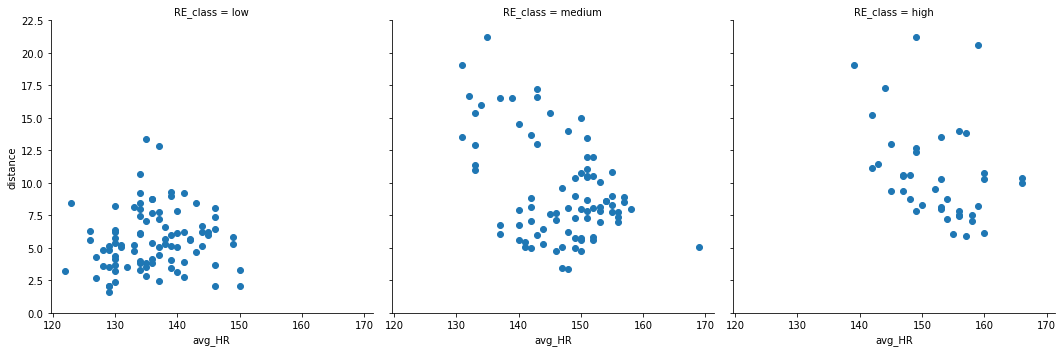

In [55]:
dist_ticks = [0,2500,5000,7500,10000,12500,15000,17500,20000,22500]
dist_labels = [v/1000 for v in dist_xticks]

g = sns.FacetGrid(data=running, col='RE_class', height=5)
g.map(plt.scatter,'avg_HR','distance')
g.set(yticks=dist_ticks)
g.set_yticklabels(dist_labels)

plt.show()

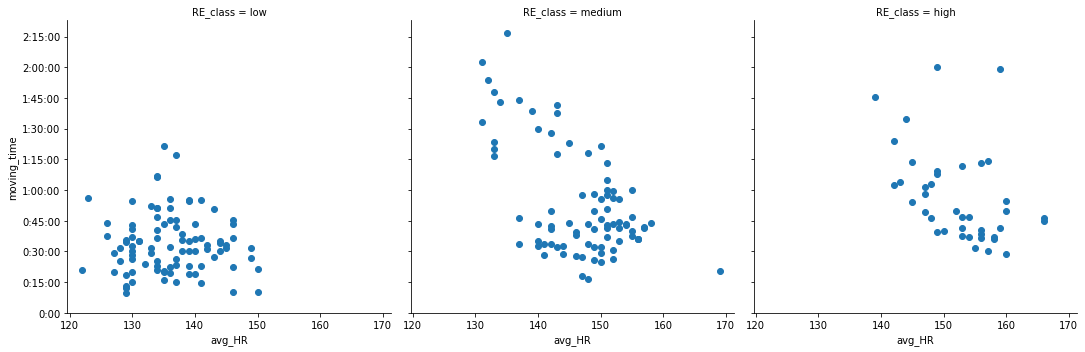

In [56]:
time_ticks = [0,900,1800,2700,3600,4500,5400,6300,7200,8100]
time_labels = [format_pace(v) for v in time_ticks]

g = sns.FacetGrid(data=running, col='RE_class', height=5)
g.map(plt.scatter,'avg_HR','moving_time')
g.set(yticks=time_ticks)
g.set_yticklabels(time_labels)

plt.show()

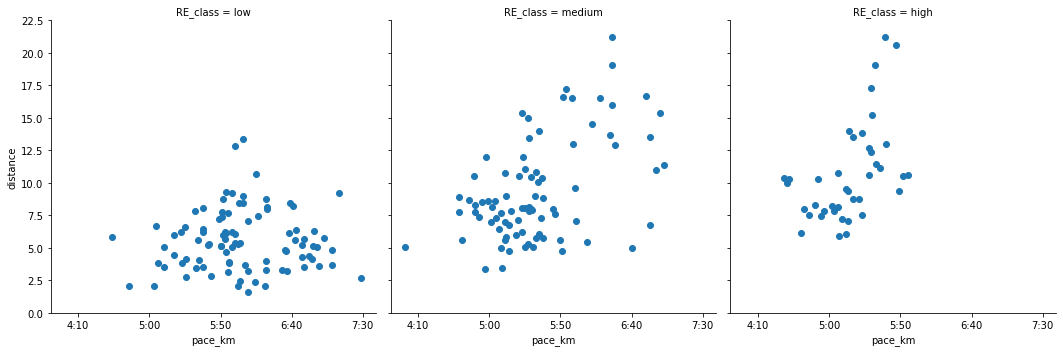

In [57]:
dist_ticks = [0,2500,5000,7500,10000,12500,15000,17500,20000,22500]
dist_labels = [v/1000 for v in dist_xticks]
pace_ticks = [250,300,350,400,450]
pace_labels = [format_pace(v) for v in pace_yticks]

g = sns.FacetGrid(data=running, col='RE_class', height=5)
g.map(plt.scatter,'pace_km','distance')
g.set(xticks=pace_ticks)
g.set_xticklabels(pace_labels)
g.set(yticks=dist_ticks)
g.set_yticklabels(dist_labels)

plt.show()

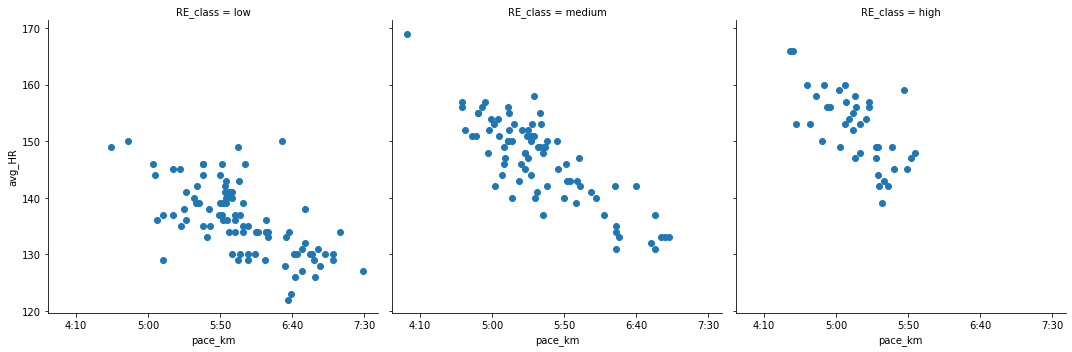

In [58]:
pace_ticks = [250,300,350,400,450]
pace_labels = [format_pace(v) for v in pace_yticks]

g = sns.FacetGrid(data=running, col='RE_class', height=5)
g.map(plt.scatter,'pace_km','avg_HR')
g.set(xticks=pace_ticks)
g.set_xticklabels(pace_labels)

plt.show()

Interpretation: While not a ton of data yet, these visual interpretations are interesting. It seems that in order for an activity to be classified as high Relative Effort, there is a minimum required average heart rate and activity time. There are no activities under 30 minutes or 140bpm that were classified as high Relative Effort. Once this threshold is crossed, a combination of higher HR (associated with faster pace) or longer exercise duration (associated with longer distance) is required to achieve a high relative effort.

It's important to note that there is multicollinearity here - where variables like distance and moving time are extremely highly correlated. This could present an issue if we were to run a regression model to predict Relative Effort of an activity

#### 3. How is my running volume trending over time? When was this the highest?

To reduce noise and daily or weekly fluctuations, I've decided to visualize this using a **30 Day Moving Average**. In order to calculate the moving average, we need a list of all dates within the range, and the distance run on each day. Right now we only have data for dates with an activity.

Step 1: Generate a list of all dates between my first and last activity:

In [1]:
def calendar_dates():
    """Generates a list of all dates between a start and end point"""

    first = running['timestamp'].dt.strftime("%d-%m-%Y").iloc[0]
    last = running['timestamp'].dt.strftime("%d-%m-%Y").iloc[-1]

    start = datetime.datetime.strptime(first, "%d-%m-%Y")
    end = datetime.datetime.strptime(last, "%d-%m-%Y")
    date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]
    
    return date_generated

Step 2: Set up two DataFrames in proper format so that they can be merged on dates.

DataFrame "all_dates" contains all calendar dates between the first and last activity
DataFrame "run_dates" contains all dates with a run, and the total distance ran

In [60]:
all_dates = pd.DataFrame(calendar_dates(), columns=['calendar_date'])
all_dates.calendar_date = all_dates.calendar_date.dt.date

run_dates = running[['timestamp','distance']]
run_dates.timestamp = run_dates.timestamp.dt.date

Step 3: Merge the two DataFrames, keeping all calendar dates and associated distances. 
- Convert all values with no activity (NaN) to 0 in order to calculate the moving average
- Convert distance to km

In [61]:
df2 = all_dates.merge(run_dates, how='left',left_on='calendar_date',right_on='timestamp')
df2.drop(columns='timestamp',inplace=True)
df2['distance'].replace(np.nan,0,inplace=True) #convert NaN to 0
df2['distance'] = df2['distance']/1000 #convert distance to km

Step 4: Add a calculated column with the 30 Day Moving Average for running distance

In [62]:
df2['30_day_MA'] = df2.iloc[:,1].rolling(window=30).sum()
df2.tail()

,calendar_date,distance,30_day_MA
1063,2021-01-28,0.0000,128.4488
1064,2021-01-29,5.0587,133.5075
1065,2021-01-30,8.0910,127.5892
1066,2021-01-31,5.3878,132.9770
1067,2021-02-01,0.0000,122.1619


Decided to add another calculated column highlighing those dates where the 30 day moving average was highest (over 120km)

In [63]:
over_120 = df2[df2['30_day_MA'] > 120]
over_120

,calendar_date,distance,30_day_MA
797,2020-05-10,13.5398,121.0409
804,2020-05-17,16.6811,126.8318
805,2020-05-18,0.0000,126.8318
806,2020-05-19,8.0726,125.6944
807,2020-05-20,3.6300,129.3244
...,...,...,...
1063,2021-01-28,0.0000,128.4488
1064,2021-01-29,5.0587,133.5075
1065,2021-01-30,8.0910,127.5892
1066,2021-01-31,5.3878,132.9770


Step 5: Plot Distance as a 30-Day Moving Average over Time

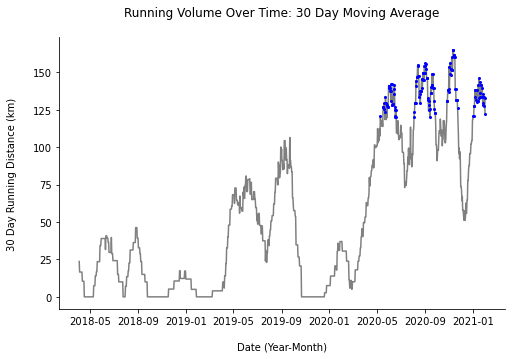

In [64]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(df2['calendar_date'],df2['30_day_MA'],c='grey')
ax.plot(over_120['calendar_date'],over_120['30_day_MA'],c='blue',marker='o',markersize=2,ls='')
ax.set_xlabel('\nDate (Year-Month)')
ax.set_ylabel('30 Day Running Distance (km)\n')
ax.set_title('Running Volume Over Time: 30 Day Moving Average\n')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

On what date was my (Running Volume 30 Day Moving Average) the highest?

In [65]:
df2.loc[df2['30_day_MA'].idxmax()]

calendar_date    2020-11-11
distance             13.806
30_day_MA           165.181
Name: 985, dtype: object

The 30 day average smooths out day to day fluctuations in the data and clearly shows the periods of time when I was running consistently. It's not surprising that 2020 was my most consistent running year, given my focus on longer, slower runs and the lack of swim workouts with pools closed due to the pandemic.

#### 4. Am I getting fitter over time?

I decided to try and create a simplistic "Fitness Score" ratio as a normalized way to compare how well I performed in each activity.

- Proposed Fitness Score ratio: Fitness Score = (Speed / Average Heart Rate) * 100

Note: A higher value indicates greater fitness. Speed is a function of distance and time, so they are also technically factored into this calculation. I am assuming that a lower heart rate and/or a higher speed are associated with higher fitness.

In [66]:
running['fitness_score'] = (running['speed_kph'] / running['avg_HR']) * 100

 Distribution of fitness scores

In [67]:
running['fitness_score'].describe()

count    216.000000
mean       7.426349
std        0.600910
min        6.100000
25%        7.074390
50%        7.351470
75%        7.744929
max       11.468966
Name: fitness_score, dtype: float64

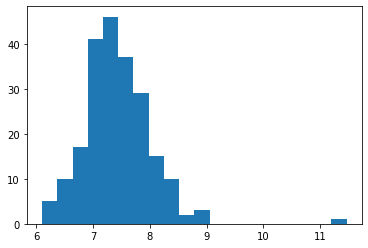

In [68]:
plt.hist(running.fitness_score,bins=20)
plt.show()

#### Which run had the highest fitness score?

In [69]:
print(running.loc[running['fitness_score'].idxmax()])

activity_id                                               3628614796
timestamp                                  2020-06-17 08:22:56-04:00
name                                                       1 Mile TT
sport                                                            Run
description        Came out of the gates way too hot...lesson lea...
relative_effort                                                    1
elapsed_time                                                     347
moving_time                                                      347
distance                                                      1602.5
elevation_gain                                                     0
cadence                                                          176
max_HR                                                           NaN
avg_HR                                                           145
avg_power                                                        NaN
calories                          

#### Which run had the lowest fitness score?

In [70]:
print(running.loc[running['fitness_score'].idxmin()])

activity_id                       3628617804
timestamp          2020-06-17 08:29:31-04:00
name                               Cool down
sport                                    Run
description                              NaN
relative_effort                           10
elapsed_time                            1348
moving_time                             1295
distance                              3291.6
elevation_gain                         13.63
cadence                                  152
max_HR                                   NaN
avg_HR                                   150
avg_power                                NaN
calories                                 299
grade_adj_dist                        3326.8
weather                                    1
temperature                            16.93
humidity                                0.57
wind_speed                              1.18
speed_kph                               9.15
pace_km                                  393
cadence_cl

#### How has my fitness score trended over time?

C:\Users\danie\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1091: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


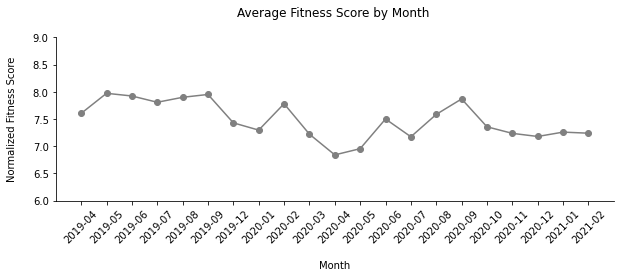

In [71]:
fitness_by_month = running.groupby(running['timestamp'].dt.to_period("M")).fitness_score.mean()
fitness_by_month = fitness_by_month.reset_index()
fitness_by_month = fitness_by_month[fitness_by_month['fitness_score'].notnull()]
fitness_by_month['timestamp'] = fitness_by_month['timestamp'].astype(str)

high_fitness = fitness_by_month[fitness_by_month.fitness_score > 8]

fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(fitness_by_month['timestamp'],fitness_by_month['fitness_score'],c='grey',marker='o')
ax.plot(high_fitness['timestamp'],high_fitness['fitness_score'],c='blue',marker='o',markersize=5,ls='')
plt.xticks(rotation=45)
ax.set_xlabel('\nMonth')
ax.set_ylabel('Normalized Fitness Score\n')
ax.set_title('Average Fitness Score by Month \n')
ax.set_ylim(bottom=6,top=9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

On a first look at this simplistic metric over time, you might conclude that I am not getting much fitter over time. However, as this is my personal data, I know there are other factors that may not be reflected here. For instance, I recently started training at a higher cadence, which boosts up heart rate without the immediate corresponding payoff in speed. I also tend to battle a lot of injuries in peak season and slack off a bit in the fall/winter. Finally, my wrist heart rate sensor is sometimes inaccurate which can lead to some inaccurate results and artificial inflation or deflation of certain months.

### Next Steps

There are a few ways I plan to enhance this analysis going forward
1. Deeper dives into my cycling and swimming data (for this project I focused on running)
2. Incorporation of other data sources to add features such as sleep and weather. This will add new dimensions to explore relationships on
3. Building an automatic ETL pipeline so that the visualizations update as I log more data. This will involve connecting programmatically to the Strava API rather than using the automatic download of files